In [1]:
import numpy as np
import os, pickle, importlib, time, random, cv2, glob

from scipy.ndimage.measurements import label
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle
from sklearn.svm import LinearSVC
from sklearn.cross_validation import train_test_split

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from vehicle_detection_utilities import *


def bing():
    '''
    This function makes a sound - to be used when model training/testing is complete

    This is actually crucial for a busy person, start the NN training, and then this function
    is called (and makes the sound) when training's done
    '''
    pygame_spec = importlib.util.find_spec('pygame')
    if pygame_spec is not None:
        import pygame
        pygame.mixer.init()
        soundObj = pygame.mixer.Sound('beep1.ogg')
        soundObj.play()
        time.sleep(2)
        soundObj.stop()

def show_images(image1, image2, image3, image4,  image1_exp="Image 1", image2_exp="Image 2", image3_exp="Image 3", image4_exp="Image 4"):
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image1)
    ax1.set_title(image1_exp, fontsize=20)
    ax2.imshow(image2)
    ax2.set_title(image2_exp, fontsize=20)
    ax3.imshow(image3)
    ax3.set_title(image3_exp, fontsize=20)
    ax4.imshow(image4)
    ax4.set_title(image4_exp, fontsize=20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

/home/ron/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Classifier Code

In [2]:
########## get the NON cars ################
non_cdf1 = "./data_vehicles_renamed2/non-vehicles/Extras/*.png"
non_cdf2 = "./data_vehicles_renamed2/non-vehicles/GTI/*.png"

notcarpaths = []
for i in [non_cdf1, non_cdf2]:
    for im_path in glob.glob(i):
        notcarpaths.append(im_path)

######### get the CAAAAs    ###################

cdf1 = "./data_vehicles_renamed2/vehicles/GTI_Far/*.png"
cdf2 = "./data_vehicles_renamed2/vehicles/GTI_Left/*.png"
cdf3 = "./data_vehicles_renamed2/vehicles/GTI_Right/*.png"
cdf4 = "./data_vehicles_renamed2/vehicles/GTI_MiddleClose/*.png"

cdf5 = "./data_vehicles_renamed2/vehicles/KITTI_extracted/*.png"

carpaths = []
for i in [cdf1,cdf2,cdf3,cdf4,cdf5]:
    for im_path in glob.glob(i):
        carpaths.append(im_path)  

### Upload images and pickle 

In [3]:
t1=time.time()


car_features    = [mpimg.imread(i) for i in carpaths]
notcar_features = [mpimg.imread(i)for i in notcarpaths]
car_features    = [get_img_features(i, **params_dict) for i in car_features]
notcar_features = [get_img_features(i, **params_dict) for i in notcar_features]

processed_training_data = [car_features,notcar_features]

with open("all_data_crcb.pickle","wb") as pklf:
    pickle.dump(processed_training_data, pklf)
'''



with open("all_data_crcb.pickle",'rb') as infile:
    car_features,notcar_features = pickle.load(infile)
'''
print("number of cars:",len(car_features))
print("Number of Non-cars",len(notcar_features))
t2 = time.time()
hogtime = round(t2-t1, 2)
print(round(t2-t1, 2), 'Seconds to extract HOG features...')


number of cars: 8792
Number of Non-cars 8968
127.08 Seconds to extract HOG features...


### Stack Features and Train the Linear SVM

In [4]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)
X_scaler = StandardScaler().fit(X)

scaled_X = X_scaler.transform(X)

y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
   scaled_X, y, test_size=0.2, random_state=rand_state)

print("Feature length is ",len(car_features[0]) )

svc = LinearSVC()

t1=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t1, 2), 'Seconds to train SVC...')
# Check the score of the SVC
accuracy = round(svc.score(X_test, y_test), 4)
accuracystr = "%.4f" % accuracy
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

Feature length is  8460
28.9 Seconds to train SVC...
Test Accuracy of SVC =  0.9764


Remember video reads in as RGB
cv2 reads in on RGB

In [17]:
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='YUV', 
                    spatial_size=(32, 32), hist_bins=32, 
                    orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):
    
    on_windows = []    
    for window in windows:
        
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))    
        features = get_img_features(test_img, **params_dict)        
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        
        prediction = clf.predict(test_features)
        
        if prediction == 0:
            on_windows.append(window)
            
    return on_windows
#GENERATES WINDOWS
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [102]:
def find_cars_maybe(input_img):    
    box_list2 = []
    box_list3 = []
    box_list4 = []
    box_list5 = []
    box_list6 = []
    box_list7 = []
    box_list8 = []
    box_list9 = []
        
    ystart = 400
    ystop = 500
    scale=1.5
    box_list = find_cars(input_img, ystart, ystop, scale, svc, 
                         X_scaler, params_dict['orient'], 
                         params_dict['pix_per_cell'], 
                         params_dict['cell_per_block'], 
                         params_dict['spatial_size'], 
                         hist_bins=32)
    ystart = 450
    ystop = 550
    scale=1.5
    box_list2 = find_cars(input_img, ystart, ystop, scale, svc, 
                         X_scaler, params_dict['orient'], 
                         params_dict['pix_per_cell'], 
                         params_dict['cell_per_block'], 
                         params_dict['spatial_size'], 
                         hist_bins=32)
    '''
    ystart = 500
    ystop = 600
    scale=1.5
    box_list3 = find_cars(input_img, ystart, ystop, scale, svc, 
                         X_scaler, params_dict['orient'], 
                         params_dict['pix_per_cell'], 
                         params_dict['cell_per_block'], 
                         params_dict['spatial_size'], 
                         hist_bins=32)  
    ystart = 550
    ystop = 650
    scale=1.5
    box_list4 = find_cars(input_img, ystart, ystop, scale, svc, 
                         X_scaler, params_dict['orient'], 
                         params_dict['pix_per_cell'], 
                         params_dict['cell_per_block'], 
                         params_dict['spatial_size'], 
                         hist_bins=32)  
    '''
    
    '''
    ystart = 400
    ystop = 656
    scale=1.5
    
    box_list2 = find_cars(input_img, ystart, ystop, scale, svc, 
                         X_scaler, params_dict['orient'], 
                         params_dict['pix_per_cell'], 
                         params_dict['cell_per_block'], 
                         params_dict['spatial_size'], 
                         hist_bins=32)
    '''
    '''
    ystart = 400
    ystop = 615
    scale = 1
    box_list3 = find_cars(input_img, ystart, ystop, scale, svc, 
                         X_scaler, params_dict['orient'], 
                         params_dict['pix_per_cell'], 
                         params_dict['cell_per_block'], 
                         params_dict['spatial_size'], 
                         hist_bins=32)
            
    
    '''
    '''
    windows = slide_window(input_img, x_start_stop=[None, None], 
                           y_start_stop=[ystart,ystop], 
                            xy_window=(128, 128), 
                           xy_overlap=(.75, .75))
    
    box_list2 = search_windows(input_img, 
                                windows,
                                svc, 
                                 X_scaler,
                                params_dict['color_space'],
                                params_dict['spatial_size'],
                                32,                     
                                params_dict['orient'], 
                               params_dict['pix_per_cell'], 
                                 params_dict['cell_per_block'], 
                                params_dict['hog_channel'],
                                 params_dict['spatial_feat'], 
                                params_dict['hist_feat'],
                                params_dict['hog_feat'])
    '''
    
    '''
    ystart = 410
    ystop = 500
    scale=1.4
    box_list3 = find_cars(input_img, ystart, ystop, scale, svc, X_scaler, t['orient'], t['pix_per_cell'], t['cell_per_block'], t['spatial_size'], hist_bins=32)
    
    ystart = 425
    ystop = 525
    scale=1
    box_list4 = find_cars(input_img, ystart, ystop, scale, svc, X_scaler, t['orient'], t['pix_per_cell'], t['cell_per_block'], t['spatial_size'], hist_bins=32)
    
    ystart = 425
    ystop = 525
    scale=1.25
    box_list5 = find_cars(input_img, ystart, ystop, scale, svc, X_scaler, t['orient'], t['pix_per_cell'], t['cell_per_block'], t['spatial_size'], hist_bins=32)
    
    ystart = 425
    ystop = 525
    scale=1.5
    box_list6 = find_cars(input_img, ystart, ystop, scale, svc, X_scaler, t['orient'], t['pix_per_cell'], t['cell_per_block'], t['spatial_size'], hist_bins=32)
    
    ystart = 450
    ystop = 550
    scale=1
    box_list7 = find_cars(input_img, ystart, ystop, scale, svc, X_scaler, t['orient'], t['pix_per_cell'], t['cell_per_block'], t['spatial_size'], hist_bins=32)
    
    ystart = 450
    ystop = 550
    scale=1.25
    box_list8= find_cars(input_img, ystart, ystop, scale, svc, X_scaler, t['orient'], t['pix_per_cell'], t['cell_per_block'], t['spatial_size'], hist_bins=32)
    
    ystart = 450
    ystop = 550
    scale=1.5
    box_list9 = find_cars(input_img, ystart, ystop, scale, svc, X_scaler, t['orient'], t['pix_per_cell'], t['cell_per_block'], t['spatial_size'], hist_bins=32)
    '''
    '''
    ystart = 415
    ystop = 525
    scale=1.5
    box_list2 = find_cars(input_img, ystart, ystop, scale, svc, X_scaler, t['orient'], t['pix_per_cell'], t['cell_per_block'], t['spatial_size'], hist_bins=32)
    
    ystart = 425
    ystop = 525
    scale=1.5
    box_list3 = find_cars(input_img, ystart, ystop, scale, svc, X_scaler, t['orient'], t['pix_per_cell'], t['cell_per_block'], t['spatial_size'], hist_bins=32)
    '''    
    box_list.extend(box_list2)
    box_list.extend(box_list3)
    box_list.extend(box_list4)
    box_list.extend(box_list5)
    box_list.extend(box_list6)
    box_list.extend(box_list7)
    box_list.extend(box_list8)
    box_list.extend(box_list9)
    #on_windows
    img = draw_boxes(input_img,box_list )
    return img, box_list

(720, 1280, 3)


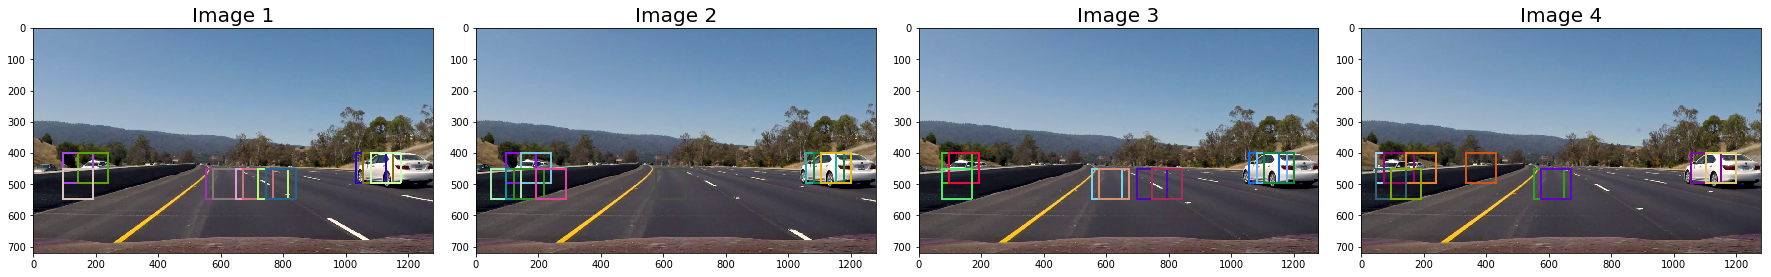

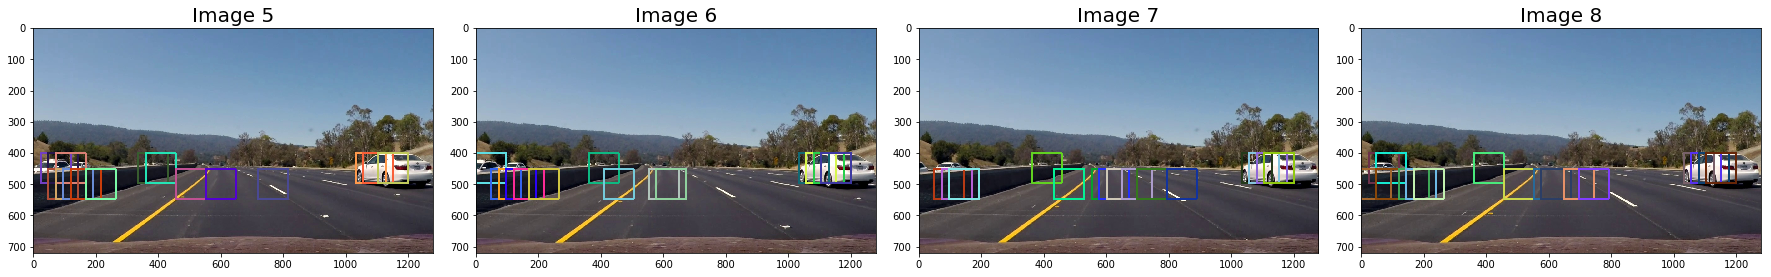

In [103]:
%matplotlib inline
image1= find_cars_maybe(mpimg.imread("./samples2/frame242.jpg") )[0]
image2= find_cars_maybe(mpimg.imread("./samples2/frame243.jpg"))[0]
image3= find_cars_maybe(mpimg.imread("./samples2/frame244.jpg"))[0]
image4= find_cars_maybe(mpimg.imread("./samples2/frame245.jpg"))[0]
image5= find_cars_maybe(mpimg.imread("./samples2/frame246.jpg"))[0]
image6= find_cars_maybe(mpimg.imread("./samples2/frame247.jpg"))[0]
image7= find_cars_maybe(mpimg.imread("./samples2/frame248.jpg"))[0]
image8= find_cars_maybe(mpimg.imread("./samples2/frame249.jpg"))[0]
print(image8.shape)
show_images(image1, image2, image3, image4,  image1_exp="Image 1", image2_exp="Image 2", image3_exp="Image 3", image4_exp="Image 4")
show_images(image5, image6, image7, image8,  image1_exp="Image 5", image2_exp="Image 6", image3_exp="Image 7", image4_exp="Image 8")

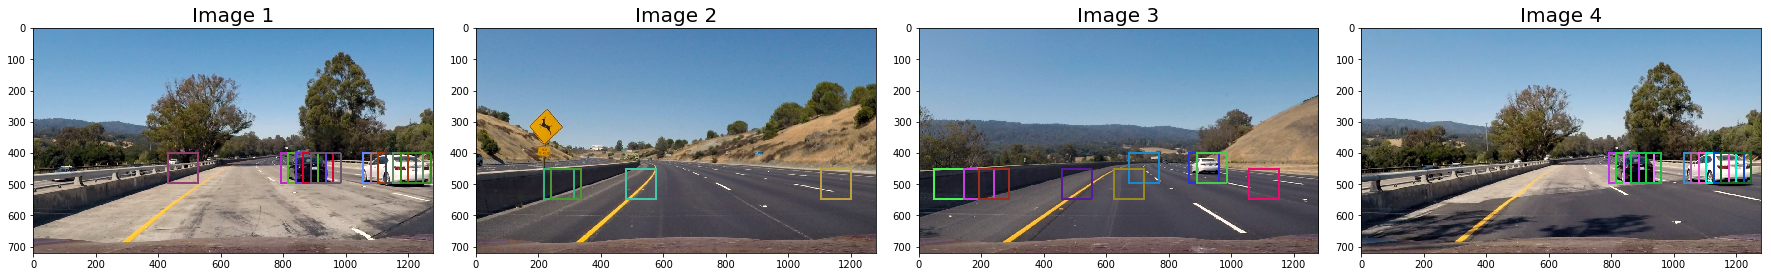

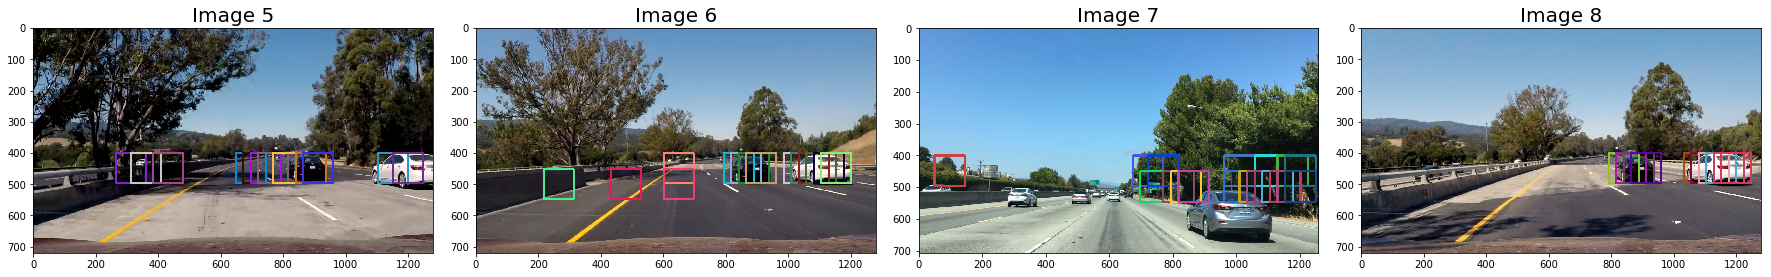

In [99]:
image1= find_cars_maybe(mpimg.imread("./test_images/test1.jpg") )[0]
image2= find_cars_maybe(mpimg.imread("./test_images/test2.jpg"))[0]
image3= find_cars_maybe(mpimg.imread("./test_images/test3.jpg"))[0]
image4= find_cars_maybe(mpimg.imread("./test_images/test4.jpg"))[0]
image5= find_cars_maybe(mpimg.imread("./test_images/test5.jpg"))[0]
image6= find_cars_maybe(mpimg.imread("./test_images/test6.jpg"))[0]
image7= find_cars_maybe(mpimg.imread("./test_images/test7.jpg"))[0]
image8= find_cars_maybe(mpimg.imread("./test_images/test8.jpg"))[0]

show_images(image1, image2, image3, image4,  image1_exp="Image 1", image2_exp="Image 2", image3_exp="Image 3", image4_exp="Image 4")
show_images(image5, image6, image7, image8,  image1_exp="Image 5", image2_exp="Image 6", image3_exp="Image 7", image4_exp="Image 8")

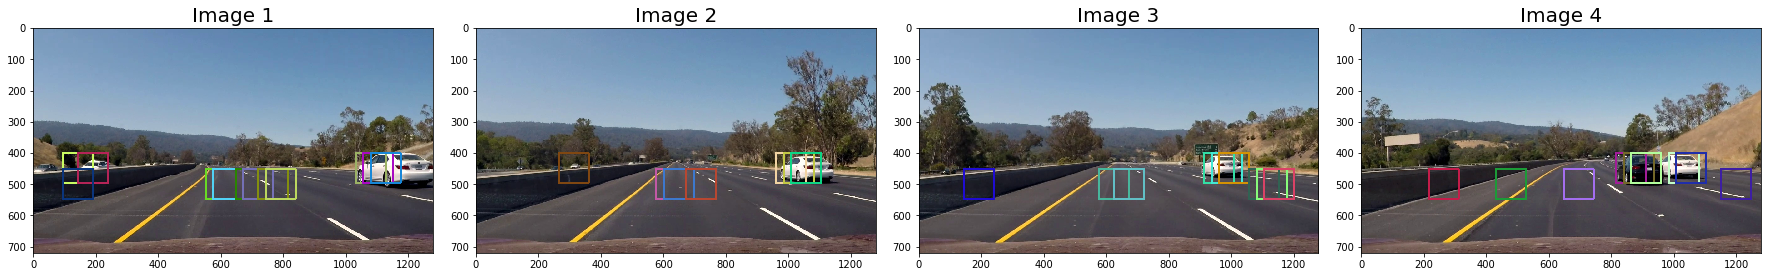

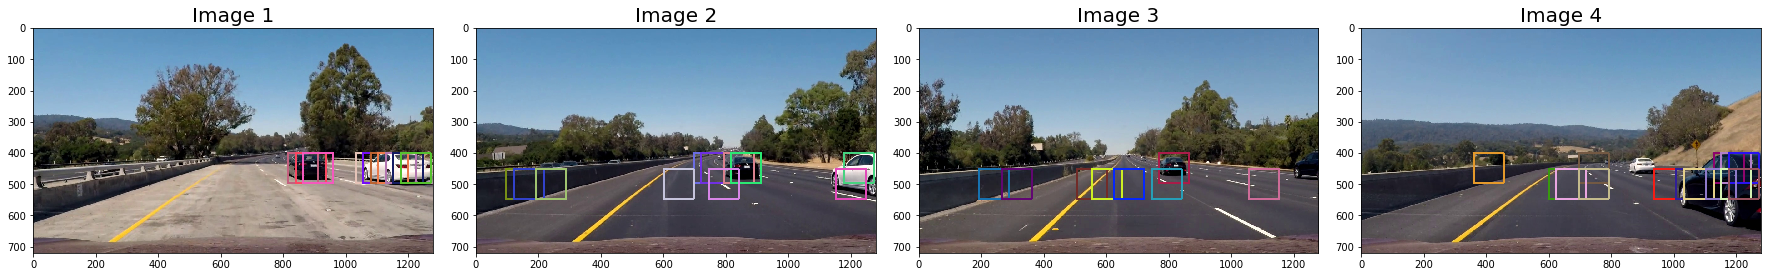

In [100]:
image1= find_cars_maybe(mpimg.imread("./samples/frame242.jpg") )[0]
image2= find_cars_maybe(mpimg.imread("./samples/frame361.jpg"))[0]
image3= find_cars_maybe(mpimg.imread("./samples/frame457.jpg"))[0]
image4= find_cars_maybe(mpimg.imread("./samples/frame895.jpg"))[0]
image5= find_cars_maybe(mpimg.imread("./samples/frame1003.jpg"))[0]
image6= find_cars_maybe(mpimg.imread("./samples/frame1117.jpg"))[0]
image7= find_cars_maybe(mpimg.imread("./samples/frame1249.jpg"))[0]
image8= find_cars_maybe(mpimg.imread("./samples/frame715.jpg"))[0]


show_images(image1, image2, image3, image4,  image1_exp="Image 1", image2_exp="Image 2", image3_exp="Image 3", image4_exp="Image 4")
show_images(image5, image6, image7, image8,  image1_exp="Image 1", image2_exp="Image 2", image3_exp="Image 3", image4_exp="Image 4")

In [124]:
from collections import deque
from scipy.ndimage.measurements import label
heatmap_que = deque(maxlen=10)

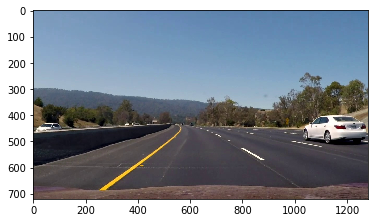

In [128]:
image1= find_cars_maybe(mpimg.imread("./samples2/frame242.jpg") )[0]
image2= find_cars_maybe(mpimg.imread("./samples2/frame243.jpg"))[0]
image3= find_cars_maybe(mpimg.imread("./samples2/frame244.jpg"))[0]
image4= find_cars_maybe(mpimg.imread("./samples2/frame245.jpg"))[0]
image5= find_cars_maybe(mpimg.imread("./samples2/frame246.jpg"))[0]
image6= find_cars_maybe(mpimg.imread("./samples2/frame247.jpg"))[0]
image7= find_cars_maybe(mpimg.imread("./samples2/frame248.jpg"))[0]
image8= find_cars_maybe(mpimg.imread("./samples2/frame249.jpg"))[0]

forheat = []
for i in range(2,10):
    filename = "./samples2/frame24" + str(i) + ".jpg"
    forheat.append( find_cars_maybe(mpimg.imread("./samples2/frame249.jpg")) )
    
#image, list8 = find_cars_maybe(mpimg.imread("./samples/frame715.jpg"))

def add_heat(heatmap, bbox_list):        
        for box in bbox_list:
            heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1            
        return heatmap
    
def apply_threshold(threshold,heatmap):

    checkmap = np.copy(heatmap)
    checkmap[checkmap <= threshold] = 0        
    return checkmap
    
def generate_heatmap(image,box_list):
        '''
        Generates the heatmap
        
        adds heatmaps and then averages the results
        
        '''
        global heatmap_que        
        
        heatmap = np.zeros_like(image[:,:,0]).astype(np.float64)       
        
        heatmap = add_heat(heatmap, box_list)
        
        heatmap = apply_threshold(2,heatmap)      
        heatmap_que.append(heatmap)
        
        the_avg = np.array(heatmap_que).mean(axis=0)
        
        the_avg = apply_threshold(1, the_avg)
        return the_avg

def draw_labeled_bboxes(img, thresholded_image):
    '''
    Legend has it thresholded_image is a heatmap
    '''
    labels = label(thresholded_image)
    
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    return img

for i in forheat:
    hmap = generate_heatmap(*i)
#
image123 = forheat[-1][0]
yeah8_img = mpimg.imread("./samples2/frame249.jpg")
thinking = draw_labeled_bboxes(image123, hmap )
plt.imshow(yeah8_img)

In [42]:


from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'results_full_pre_heatmap.mp4'
clip1 = VideoFileClip("project_video.mp4")
clip2 = clip1.subclip(35,37)
white_clip = clip1.fl_image(find_cars_maybe)
%time white_clip.write_videofile(white_output, audio=False)
bing()



[MoviePy] >>>> Building video results_full_pre_heatmap.mp4
[MoviePy] Writing video results_full_pre_heatmap.mp4


 21%|██        | 260/1261 [01:14<04:44,  3.51it/s]

KeyboardInterrupt: 